In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import tensorflow as tf
import os
import time

In [2]:
import sys
sys.path.append('..')
import projector.ct_projector_tensorflow as ct_projector_tf

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# load a sample CT image
filename = './3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis,...]
img = img[:, ::-1, ...]
spacing = np.array(spacing[::-1])

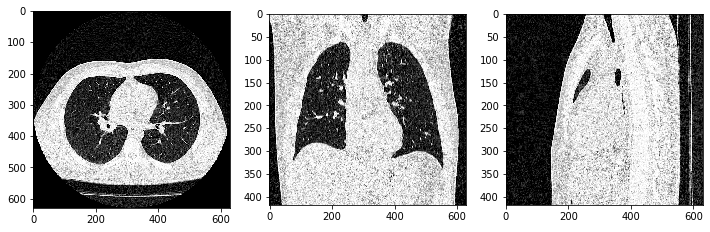

In [5]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[0, :, img.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[0, ..., img.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

In [6]:
# setup the projector
projector = ct_projector_tf.ct_projector()
projector.from_file('./projector.cfg')
projector.nx = img.shape[3]
projector.ny = img.shape[2]
projector.nz = img.shape[1]
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 2
nu = 2048
nv = 3072
nx = 630
ny = 630
nz = 418
dx = 0.6835939884185791
dy = 0.6835939884185791
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 3000.0
dso = 2700.0
du = 0.25
dv = 0.25
off_u = 0
off_v = 0
geometry = <configparser.ConfigParser object at 0x7f416d499a10>


In [7]:
# setup the positions of projections, let's do 0, 45, 90, and 135
angles = np.array([0, 45, 90, 135]) * np.pi / 180

srcs = np.array([projector.dso * np.cos(angles), 
                 projector.dso * np.sin(angles), 
                 [0] * len(angles)]).T

det_centers = np.array([(projector.dso - projector.dsd) * np.cos(angles), 
                        (projector.dso - projector.dsd) * np.sin(angles), 
                        [0] * len(angles)]).T

det_us = np.array([-np.sin(angles), np.cos(angles), [0] * len(angles)]).T
det_vs = np.zeros_like(det_us)
det_vs[:, 2] = 1

In [8]:
geometry = projector.make_geometry(det_centers, det_us, det_vs, srcs)
bp_angles = [2]
bp_geometry = projector.make_geometry(det_centers[bp_angles], det_us[bp_angles], det_vs[bp_angles], srcs[bp_angles])

In [9]:
img1 = np.copy(img)[...,np.newaxis]
img2 = np.copy(img)[...,np.newaxis]
img2 = img2[:, ::-1, ...]
img_input = np.concatenate((img1, img2), -1)

In [10]:
with tf.compat.v1.Session() as sess:
    img_holder = tf.compat.v1.placeholder(tf.float32, [None, projector.nx, projector.ny, projector.nz, 2])
    detector_holder = tf.compat.v1.placeholder(tf.float32, [4])
    prj_tensor = projector.siddon_cone_fp_abitrary(img_holder, geometry)
    
    prj_holder = tf.compat.v1.placeholder(tf.float32, [None, projector.nu, projector.nv, len(bp_angles), 2])
    geometry_holder = tf.compat.v1.placeholder(tf.float32, [len(bp_angles)*4, 3])
    bp_tensor = projector.siddon_cone_bp_abitrary(prj_holder, bp_geometry)
    
    fp = sess.run(prj_tensor, {img_holder: img_input.transpose([0, 3, 2, 1, 4])})
    bp = sess.run(bp_tensor, {prj_holder: fp[..., bp_angles, :]})
    bp_norm = sess.run(bp_tensor, {prj_holder: np.ones(fp[..., bp_angles, :].shape, np.float32), geometry_holder: bp_geometry})
    
    bp = bp / (bp_norm + 1e-4)

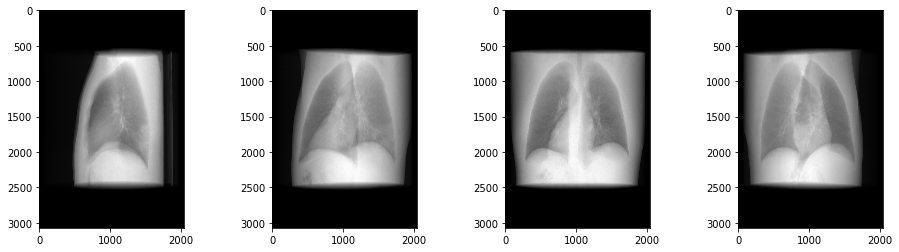

In [11]:
# show the projections
plt.figure(figsize = (16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(fp[0, ..., i, 0].T, 'gray')

5.9263244


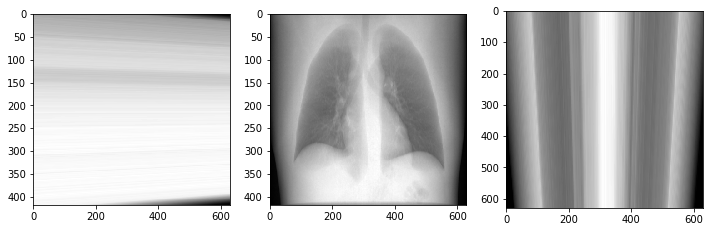

In [12]:
ichannel = 0
print (bp.max())
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(bp[0, bp.shape[1]//2, ..., ichannel].T, 'gray', aspect=spacing[0] / spacing[1])
plt.subplot(132); plt.imshow(bp[0, :, bp.shape[2]//2, :, ichannel].T, 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(bp[0, ..., bp.shape[3]//2, ichannel].T, 'gray', aspect=spacing[1] / spacing[2])